![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

<center><h1>Bug Comparison with Doc2Vec</h1></center>

This notebook is a demonstration of using Doc2Vec as an approach to compare the text of bug reports from an open source Bugzilla project. The Doc2Vec model from gensim is based on the word2vec paper but includes an additional input that identifies the document in the input.

Personal opinion is that the API is difficult to understand with little tutorial material avaialble for how to implement this model in a practical solution.

API doc [here](https://radimrehurek.com/gensim/models/doc2vec.html)

Based on the paper [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053v2.pdf) by Quoc Le and Tomas Mikolov.


# Experiments

1. stop words vs no stop words

2. Try different instantiations of the Doc2Vec

3. Try training pre-trained wikipedia version


In [1]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import spacy
import gensim
import collections
import statistics

# Loading Bugzilla Data

The data for this notebook was put together from the Eclipse XText project Bugzilla. You can find a link [here](https://bugs.eclipse.org/bugs/buglist.cgi?component=Xtext&product=TMF)

The bugs and associated comments were loaded into a pandas dataframe and stored in parquet format.



In [2]:
url = 'https://github.com/HSV-AI/bug-analysis/raw/master/data/df-xtext.parquet.gzip'
df = pd.read_parquet(url)

# Creating a Tokenize Method

The tokenize method is used by the Doc2Vec model to extract a list of words from a document. This method can have major impacts on the performance of the model based on how it is configured. There are different approaches for TF-IDF that drop out many of the words that do not work for the Doc2Vec approach where the order of the words matters.

Other things that work well with probabilistic approaches like capturing the lemma of the word instead of the actual word may actually reduce the accuracy of the Doc2Vec model.


In [3]:
text = """    java.lang.ClassCastException: HIDDEN
    at org.eclipse.xtext.xbase.ui.debug.XbaseBreakpointDetailPaneFactory.getDetailPaneTypes(XbaseBreakpointDetailPaneFactory.java:42)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager$DetailPaneFactoryExtension.getDetailPaneTypes(DetailPaneManager.java:94)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager.getPossiblePaneIDs(DetailPaneManager.java:385)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager.getPreferredPaneFromSelection(DetailPaneManager.java:285)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneProxy.display(DetailPaneProxy.java:109)
    at org.eclipse.jdt.internal.debug.ui.ExpressionInformationControlCreator$ExpressionInformationControl$2.updateComplete(ExpressionInformationControlCreator.java:344)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider$4.run(TreeModelContentProvider.java:751)
    at org.eclipse.core.runtime.SafeRunner.run(SafeRunner.java:42)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider.notifyUpdate(TreeModelContentProvider.java:737)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider.updatesComplete(TreeModelContentProvider.java:653)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider.performUpdates(TreeModelContentProvider.java:1747)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider.access$10(TreeModelContentProvider.java:1723)
    at org.eclipse.debug.internal.ui.viewers.model.TreeModelContentProvider$6.run(TreeModelContentProvider.java:1703)
    at org.eclipse.swt.widgets.RunnableLock.run(RunnableLock.java:35)
    at org.eclipse.swt.widgets.Synchronizer.runAsyncMessages(Synchronizer.java:136)
    at org.eclipse.swt.widgets.Display.runAsyncMessages(Display.java:4147)
    at org.eclipse.swt.widgets.Display.readAndDispatch(Display.java:3764)
    at org.eclipse.e4.ui.internal.workbench.swt.PartRenderingEngine$9.run(PartRenderingEngine.java:1151)
    at org.eclipse.core.databinding.observable.Realm.runWithDefault(Realm.java:337)
    at org.eclipse.e4.ui.internal.workbench.swt.PartRenderingEngine.run(PartRenderingEngine.java:1032)
    at org.eclipse.e4.ui.internal.workbench.E4Workbench.createAndRunUI(E4Workbench.java:156)
    at org.eclipse.ui.internal.Workbench$5.run(Workbench.java:648)
    at org.eclipse.core.databinding.observable.Realm.runWithDefault(Realm.java:337)
    at org.eclipse.ui.internal.Workbench.createAndRunWorkbench(Workbench.java:592)
    at org.eclipse.ui.PlatformUI.createAndRunWorkbench(PlatformUI.java:150)
    at org.eclipse.ui.internal.ide.application.IDEApplication.start(IDEApplication.java:138)
    at org.eclipse.equinox.internal.app.EclipseAppHandle.run(EclipseAppHandle.java:196)
    at org.eclipse.core.runtime.internal.adaptor.EclipseAppLauncher.runApplication(EclipseAppLauncher.java:134)
    at org.eclipse.core.runtime.internal.adaptor.EclipseAppLauncher.start(EclipseAppLauncher.java:104)
    at org.eclipse.core.runtime.adaptor.EclipseStarter.run(EclipseStarter.java:380)
    at org.eclipse.core.runtime.adaptor.EclipseStarter.run(EclipseStarter.java:235)
    at sun.reflect.NativeMethodAccessorImpl.invoke0(null:-2)
    at sun.reflect.NativeMethodAccessorImpl.invoke(null:-1)
    at sun.reflect.DelegatingMethodAccessorImpl.invoke(null:-1)
    at java.lang.reflect.Method.invoke(null:-1)
    at org.eclipse.equinox.launcher.Main.invokeFramework(Main.java:648)
    at org.eclipse.equinox.launcher.Main.basicRun(Main.java:603)
    at org.eclipse.equinox.launcher.Main.run(Main.java:1465)"""

exception_regex = re.compile(r"(?m)^.*?Exception.*(?:[\r\n]+^\s*at .*)+", re.MULTILINE | re.IGNORECASE)
exception_regex.sub("", text)

''

In [4]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize_spacy(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
#            if re.fullmatch('[a-zA-Z]+', token.text) and not token.is_stop:
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
            if re.fullmatch('[a-zA-Z]+', token.text):
#                 filtered_tokens.append(token.lemma_)
                filtered_tokens.append(token.text)
    return filtered_tokens


# TaggedDocument

The Word2Vec model uses an array of TaggedDocuments as input for training. The TaggedDocument consists of an array of words/tokens (from our tokenizer) and a list of tags. In our case, the tags used only includes the ID of the bug.


In [5]:
def read_corpus():
  for i, row in df.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize_spacy(row['text']), [row['id']])

train_corpus = list(read_corpus())

Let's take a look at a random TaggedDocument in the corpus. This is a good check to see what the tokenizer is providing based on the text of the bug.

In [6]:
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
tag = doc.tags[0]
print(tag,doc.words)
text = df.iloc[doc_id]['text']
print('\n',text)

363914 ['Check', 'that', 'you', 'can', 'not', 'append', 'a', 'null', 'segment', 'to', 'a', 'QualifiedName', 'Build', 'Identifier', 'Just', 'a', 'minor', 'enhancement', 'The', 'factory', 'checks', 'that', 'you', 'can', 'not', 'create', 'a', 'qualified', 'name', 'with', 'a', 'null', 'segment', 'However', 'the', 'function', 'does', 'not', 'Would', 'be', 'better', 'to', 'always', 'guarantee', 'the', 'non', 'null', 'invariant', 'and', 'also', 'check', 'the', 'parameter', 'of', 'the', 'append', 'operation', 'Reproducible', 'Always', 'fixed', 'pushed', 'to', 'master', 'We', 'have', 'to', 'make', 'sure', 'that', 'no', 'client', 'code', 'in', 'the', 'frameworks', 'passes', 'null', 'to', 'As', 'as', 'discussed', 'internally', 'I', 'removed', 'the', 'null', 'check', 'for', 'now', 'since', 'it', 'might', 'lead', 'to', 'new', 'exceptions', 'in', 'clients', 'The', 'plan', 'is', 'to', 'apply', 'the', 'apply', 'the', 'null', 'check', 'again', 'right', 'after', 'we', 'have', 'release', 'Xtext', 'This',

# Doc2Vec Model

Believe it or not, there are 22 available parameters for use in the constructor with 21 being optional. The API also does not list the defaults for the optional parameters.

The required parameter is the vector of tagged documents to use for training.

The best way to figure this out is to use

```??gensim.models.doc2vec.Doc2Vec()```

in a notebook cell.

Copying the text of the method headers gives us:

    Doc2Vec(documents=None, dm_mean=None, dm=1, dbow_words=0, dm_concat=0, dm_tag_count=1, docvecs=None, docvecs_mapfile=None, comment=None, trim_rule=None, callbacks=(), **kwargs)

    BaseWordEmbeddingsModel(sentences=None, workers=3, vector_size=100, epochs=5, callbacks=(), batch_words=10000, trim_rule=None, sg=0, alpha=0.025, window=5, seed=1, hs=0, negative=5, cbow_mean=1, min_alpha=0.0001, compute_loss=False, fast_version=0, **kwargs)



dm ({1,0}, optional) – Defines the training algorithm. 

If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.

This is similar to the skip-gram method vs DBOW method for word vectors.

The Distributed Memory version takes the order of the words into account when categorizing the document vectors, so we will use that version.

## Building Vocabulary

The first step in setting up the model is to build the vocabulary using the list of tagged documents.

    model.build_vocab(documents, update=False, progress_per=10000, keep_raw_vocab=False, trim_rule=None, **kwargs)

## Training the model

The final step is training the model.

     model.train(documents, total_examples=None, total_words=None, epochs=None, start_alpha=None, end_alpha=None, word_count=0, queue_factor=2, report_delay=1.0, callbacks=())

In [7]:
model = gensim.models.doc2vec.Doc2Vec(min_count=2, epochs=40)
%time model.build_vocab(train_corpus)
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)


CPU times: user 5.68 s, sys: 56.1 ms, total: 5.73 s
Wall time: 5.27 s
CPU times: user 1min 7s, sys: 655 ms, total: 1min 8s
Wall time: 26.9 s


In [9]:
model.save('bugzilla.doc2vec')

??model.save()

# Using the Doc2Vec Model

The easiest way to use the model is with the *most_similar* method. This method will return a list of the most similar tagged documents based on the label passed into the method. For our use, we pass in the ID of the bug that we want to find a similar bug for.

    model.docvecs.most_similar(positive=None, negative=None, topn=10, clip_start=0, clip_end=None, indexer=None)

In [8]:
model.docvecs.most_similar(231773)

[(348199, 0.6316051483154297),
 (287550, 0.6027359962463379),
 (266427, 0.588177502155304),
 (287071, 0.5791216492652893),
 (266426, 0.576055109500885),
 (362787, 0.5739638805389404),
 (366414, 0.5676364898681641),
 (288103, 0.5655356645584106),
 (298734, 0.5629502534866333),
 (457006, 0.5558722019195557)]

The previous method only works from a previously known (and trained) label from a tagged document. The other way to use the model is find the most similar tagged document based on a list of words. In order to do this:

1. Get a list of words from a new document
2. **Important!** Tokenize this list of words using the same tokenizer used when creating the corpus
3. Convert the list of tokens to a vector using the **infer_vector** method
4. Call the **most_similar** method with the new vector

In [9]:
from scipy import spatial

text1 = df.iloc[0,:]['text']
text2 = tokenize_spacy(text1)
vector = model.infer_vector(text2)

similar = model.docvecs.most_similar([vector])
print(similar)


[(231773, 0.8523540496826172), (266426, 0.6661572456359863), (287550, 0.6446412801742554), (476754, 0.6223310828208923), (266427, 0.6220518350601196), (312276, 0.6161692142486572), (473712, 0.613205075263977), (348199, 0.6111923456192017), (402990, 0.6109021902084351), (529006, 0.6108258366584778)]


# Evaluating the Doc2Vec Model

Of course, it is helpful that our model returned the ID of the document that we vectorized and passed into the most_similar method. If this model is to be useful, each document in the corpus should be similar to itself. Using a cosine similarity metric, we can calculate the self-similarity of each document.

We'll calculate the self-similarity below and graph the distribution to see what we have.


/opt/tools/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


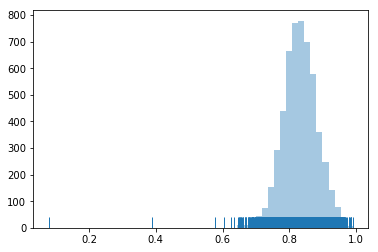

In [10]:
similarities = []
for doc_id in range(len(train_corpus)):
    learned_vector = model.docvecs[train_corpus[doc_id].tags[0]]
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    distance = 1 - spatial.distance.cosine(learned_vector, inferred_vector)
    similarities.append(distance)
    
sns.distplot(similarities, kde=False, rug=True)

# Check Outliers

Let's look at any items that are not self similar based on the model.

In [11]:
print(min(similarities))
index = similarities.index(min(similarities))
print(df.iloc[index,:])

0.0787610188126564
component                       Website
date          2013-07-16 07:03:42+00:00
id                               413031
product                             TMF
reporter        dixit.pawan@hotmail.com
resolution                   WORKSFORME
status                           CLOSED
text                  fgbnghjm  cvbndfh
title                          fgbnghjm
year                               2013
month                            2013-7
day                          2013-07-16
Name: 3581, dtype: object


Given that the text consists of "fgbnghjm  cvbndfh", you can see why this bug is not handled well by the model.

We can also look at the distribution of the next similar document probabililties.

/opt/tools/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.600508476063155
0.10128021819227365


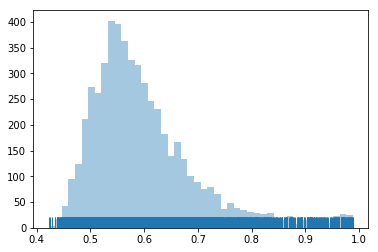

In [12]:
next_similar = []
for doc_id in range(len(train_corpus)):
    sims = model.docvecs.most_similar(train_corpus[doc_id].tags[0])
    next_similar.append(sims[0][1])
    
sns.distplot(next_similar, kde=False, rug=True)

print(statistics.mean(next_similar))
print(statistics.stdev(next_similar))

# Detecting Near Duplicates

Looking into the most similar bugs that have a very high probability (>98%), it appears that we have an issue with the tokenizer when it runs across a Java stack trace.

In [13]:
print(max(next_similar))
index = next_similar.index(max(next_similar))
bug_id = df.iloc[index,:]['id']
print(bug_id,df.iloc[index,:]['text'])

print('\n\n')

sims = model.docvecs.most_similar(bug_id)
text = df.loc[df['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)



0.9883251190185547
461367 CCE in XbaseBreakpointDetailPaneFactory.getDetailPaneTypes (42)  The following incident was reported via the automated error reporting:


    code:                   120
    plugin:                 org.eclipse.debug.ui_3.11.0.v20150116-1131
    message:                HIDDEN
    fingerprint:            a8a83b9f
    exception class:        java.lang.ClassCastException
    exception message:      HIDDEN
    number of children:     0
    
    java.lang.ClassCastException: HIDDEN
    at org.eclipse.xtext.xbase.ui.debug.XbaseBreakpointDetailPaneFactory.getDetailPaneTypes(XbaseBreakpointDetailPaneFactory.java:42)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager$DetailPaneFactoryExtension.getDetailPaneTypes(DetailPaneManager.java:94)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager.getPossiblePaneIDs(DetailPaneManager.java:385)
    at org.eclipse.debug.internal.ui.views.variables.details.DetailPaneManager.ge

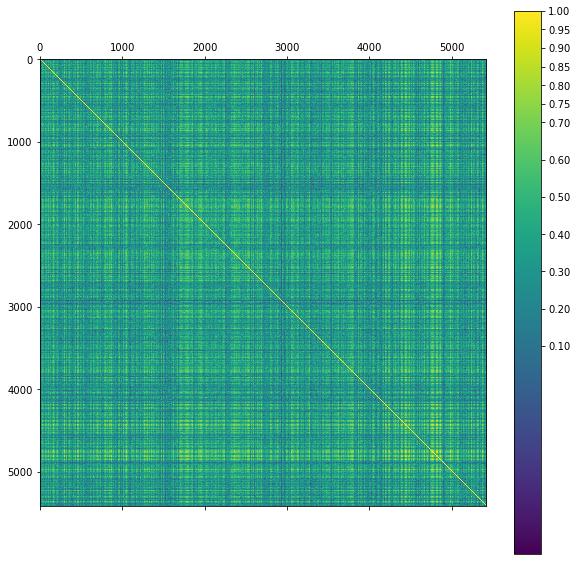

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

X = []
for doc_id in range(len(train_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    X.append(inferred_vector)
    
matrix = cosine_similarity(X)
 
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(matrix, interpolation='nearest')
fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
plt.show()

# Finding Similar Bugs

Of course, the final test to see if this model will provide a useful return value is to do a random sample and then find the most similar bug.

In [15]:
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]

text = df.loc[df['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)

sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print("\n\nDocument that is",sims[1][1]," similar below\n\n")

text = df.loc[df['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)


288444 [validation] quickfixes for unresolved references  A common use case for quickfixes will be to create an object corresponding to an unresolved cross reference. In order for Xtext to support this use case the following changes should be made:

1. The Xtext resource diagnostic interface (org.eclipse.xtext.diagnostics.Diagnostic) should provide some kind of getCode() method similar to what the TransformationDiagnostic implementation already has. Possibly it should also provide getters for the triggering AbstractNode, EObject, and StructuralFeature (allthough it should be possible to derive this from the offset and length) as this may be required to implement a corresponding quickfix.

2. Using the resource diagnostic's code the IXtextResourceChecker (and ValidationJob) can produce an Eclipse marker having a corresponding code attribute set accordingly. This however also requires investigating the marker type to use for resource diagnostics.

3. AbstractDeclarativeQuickfixProvider s

# Clustering the Embedding Space

We can use KMeans to divide the embeddings into clusters based on cosine similarity.

In [16]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=10)
kmeans.fit(X)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [17]:
print(kmeans.cluster_centers_.shape)
print(kmeans.labels_.shape)
print(kmeans.labels_)

clusters = kmeans.labels_.tolist()
df['cluster'] = clusters
# print(train_corpus)
# l = kmeans.fit_predict(model.docvecs.vectors_docs)

(10, 100)
(5415,)
[9 1 1 ... 6 7 2]


[9 1 1 ... 6 7 2]


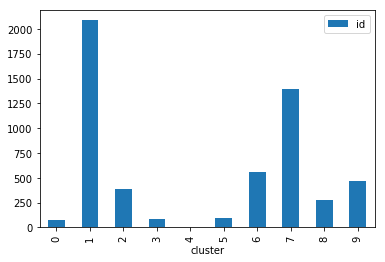

In [18]:
labels = kmeans.labels_
print(kmeans.labels_)

bugs = { 'id': df.loc[:,'id'], 'cluster': clusters }
frame = pd.DataFrame(bugs)
temp = frame.loc[:,['id','cluster']].groupby('cluster').count().plot.bar()
plt.show()

# Visualizing the Embedding Space

To visualize the space of the embedding, we will use TSNE to reduce from 100 to 2 dimensions.

In [19]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


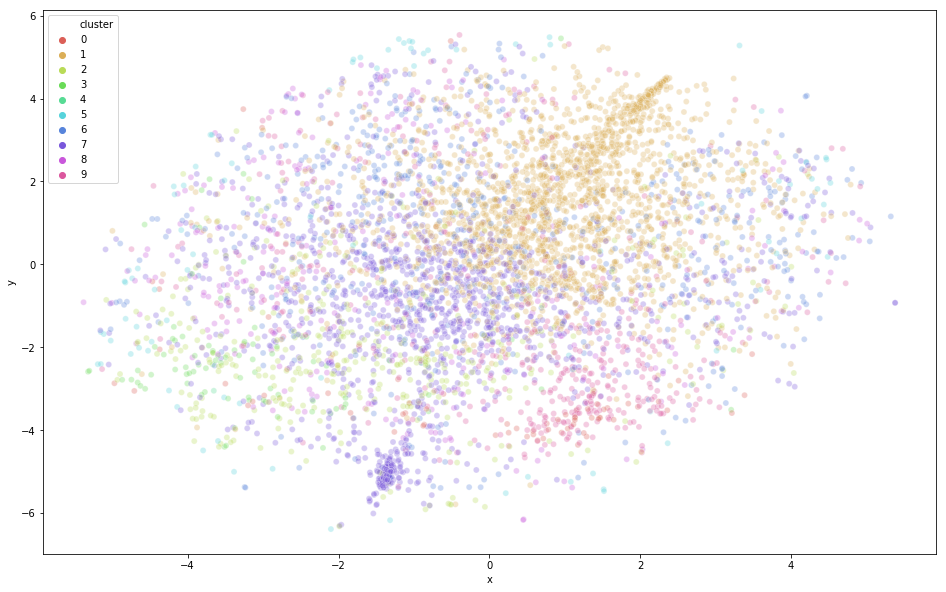

In [20]:
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(x='x', y='y', hue="cluster", palette=sns.color_palette("hls", 10), legend="full", alpha=0.3, data=df)

Now how about doing it in 3D?

In [21]:
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=3,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(np.array(X))


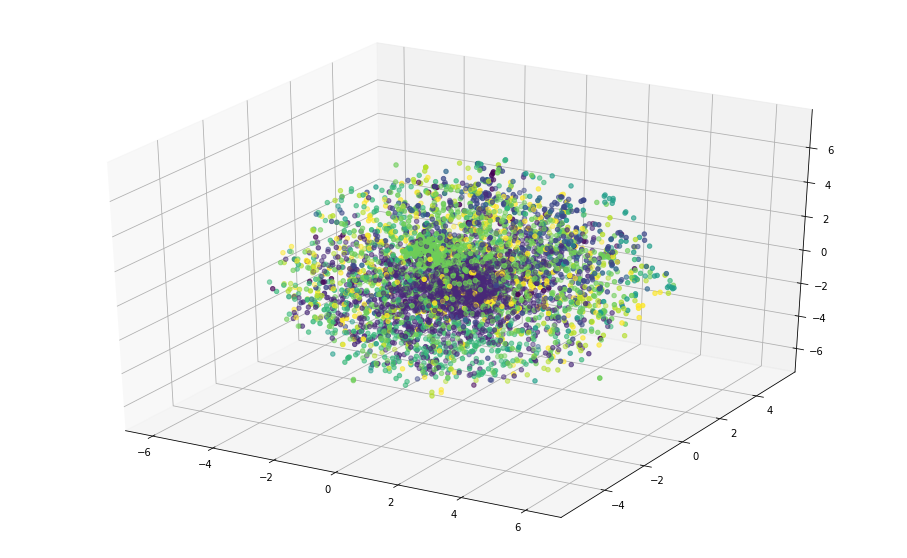

In [22]:
from mpl_toolkits.mplot3d import Axes3D

df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
df['z'] = tsne_d2v[:,2]

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter( xs=df.loc[:,"x"], ys=df.loc[:,"y"], zs=df.loc[:,"z"], c=df.loc[:,"cluster"])
plt.show()

Another method that I've seen used is to use PCA to perform an initial reduction in dimension and then TSNE to get the dimensions down to 2.

In [23]:
from sklearn.decomposition import PCA

pca_20 = PCA(n_components=20)
pca_result_20 = pca_20.fit_transform(X)

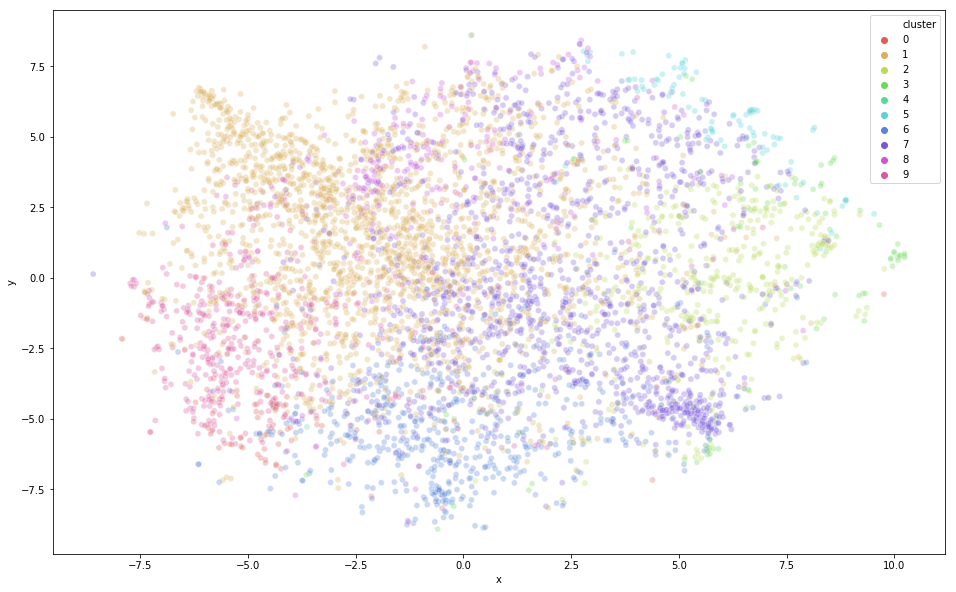

In [24]:
tsne_d2v = tsne_model.fit_transform(np.array(pca_result_20))
df['x'] = tsne_d2v[:,0]
df['y'] = tsne_d2v[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot( x='x', y='y', hue="cluster", palette=sns.color_palette("hls", 10), legend="full", alpha=0.3, data=df )

# Transfer Learning

Now that we have some idea of what we're working with, let's see if transfer learning is an option with Doc2Vec. To do this, we'll start with a distributed memory Doc2Vec model that was trained on the WikiPedia corpus. Then we will further train the model on our bug corpus and see what the results are.

In [30]:
from gensim.models.doc2vec import Doc2Vec
loadedModel = Doc2Vec.load('PV-DBOW.doc2vec')
print(loadedModel.corpus_count)

4841417


In [31]:
%time loadedModel.train(train_corpus, total_examples=model.corpus_count, epochs=20)


CPU times: user 6min 47s, sys: 1.91 s, total: 6min 49s
Wall time: 1min 3s


/opt/tools/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


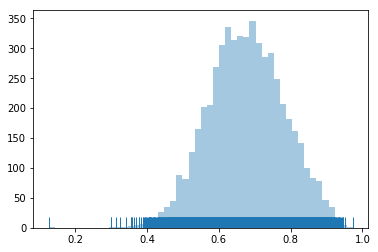

In [32]:
similarities = []
for doc_id in range(len(train_corpus)):
    learned_vector = loadedModel.docvecs[train_corpus[doc_id].tags[0]]
    inferred_vector = loadedModel.infer_vector(train_corpus[doc_id].words)
    distance = 1 - spatial.distance.cosine(learned_vector, inferred_vector)
    similarities.append(distance)
    
sns.distplot(similarities, kde=False, rug=True)

/opt/tools/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


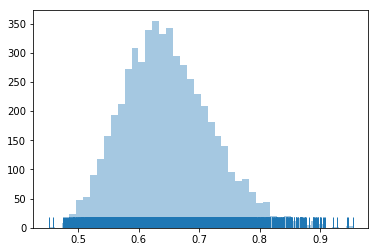

In [33]:
next_similar = []
for doc_id in range(len(train_corpus)):
    sims = loadedModel.docvecs.most_similar(train_corpus[doc_id].tags[0])
    next_similar.append(sims[0][1])
    
sns.distplot(next_similar, kde=False, rug=True)

In [34]:
import statistics

print(statistics.mean(next_similar))
print(statistics.stdev(next_similar))

0.6487272019641661
0.0749555443609924
